# Beer Data Analysis

## Table of Contents
- [Tasks](#tasks)
- [Exploratory Analysis](#exploratory-analysis)
- [Analysis](#analysis)
  - [Top 3 breweries producing strongest beers](#strongest-beers)
  - [Year of highest ratings](#highest-ratings)
  - [Important factors for taste, aroma, appearance, and palette](#important-factors)
  - [Top 3 recommendations](#top-recommendations)
  - [Best beer style](#beer-style)

## Exploratory Analysis <a id='exploratory-analysis'></a>

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap

# Natural language processing
from nltk import download
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Read data
df = pd.read_csv('data/raw/BeerDataScienceProject.tar.bz2', compression='bz2')

In [3]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the data set.')

There are 528870 rows and 13 columns in the data set.


In [4]:
# Show first 5 rows
df.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206


- There are two ID columns: beer id and beer brewer id
- There are columns to describe the beer: ABV content, name, and style
- The columns for the review describing the beer include: appearance, palette, overall score, taste, aroma, and review text
  - There are also columns for reviewer name and review time (in UNIX timestamp)

In [5]:
# Summary statistics for review columns
df[['review_appearance', 'review_palette', 'review_overall', 'review_taste', 'review_aroma']].describe()

,review_appearance,review_palette,review_overall,review_taste,review_aroma
count,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000
mean,3.864522,3.758926,3.833197,3.765993,3.817350
std,0.604010,0.685335,0.709962,0.669018,0.718903
min,0.000000,1.000000,0.000000,1.000000,1.000000
25%,3.500000,3.500000,3.500000,3.500000,3.500000
50%,4.000000,4.000000,4.000000,4.000000,4.000000
75%,4.000000,4.000000,4.500000,4.000000,4.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000


The minimum value in the `review_appearance` and `review_overall` columns is 0. These zero values *may* be errors so rows containing them will be excluded from this analysis.

In [6]:
# Select positive values only in `review_appearance` and `review_overall` columns
df = df[(df['review_appearance'] > 0) & (df['review_overall'] > 0)]

In [7]:
# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 528867 entries, 0 to 528869
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            508587 non-null  float64
 1   beer_beerId         528867 non-null  int64  
 2   beer_brewerId       528867 non-null  int64  
 3   beer_name           528867 non-null  object 
 4   beer_style          528867 non-null  object 
 5   review_appearance   528867 non-null  float64
 6   review_palette      528867 non-null  float64
 7   review_overall      528867 non-null  float64
 8   review_taste        528867 non-null  float64
 9   review_profileName  528752 non-null  object 
 10  review_aroma        528867 non-null  float64
 11  review_text         528748 non-null  object 
 12  review_time         528867 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 56.5+ MB


In [8]:
# Check missing values
df.isna().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName      115
review_aroma              0
review_text             119
review_time               0
dtype: int64

In [9]:
print(f'There are {df.isna().any(axis=1).sum()} rows with null values.')
print(f'These rows represent {round(((df.isna().any(axis=1).sum()) / len(df) * 100), 2)}% of the data.')

There are 20512 rows with null values.
These rows represent 3.88% of the data.


Assuming the null values are errors in data collection, the rows containing them will be exluded from the data.

In [10]:
# Drop rows with missing values
df = df.dropna()

In [11]:
# Check shape of DataFrame
df.shape

(508355, 13)

In [12]:
# Check multiple reviews by profile name and beer id
df.groupby(by=['review_profileName', 'beer_beerId'], as_index=False).agg(n_reviews=('review_profileName', 'count')).query('n_reviews > 1')

,review_profileName,beer_beerId,n_reviews
124,100floods,30420,2
201,11osixBrew,1904,2
253,1759Girl,1904,2
608,2girls1hop,9970,2
842,3Vandoo,16558,2
...,...,...,...
502999,zimm421,13896,2
503218,zoolzoo,57259,2
503223,zoolzoo,61593,2
503311,zoso1967,19960,2


There were users who provided more than one review for each beer. In this case, *only* the highest overall review score by each user will be included to ensure the data is consistent with one review per beer for each user.

In [13]:
df = df.sort_values(by='review_overall', ascending=False).drop_duplicates(subset=['review_profileName', 'beer_beerId'], keep='first')

In [14]:
df.shape

(503697, 13)

## Analysis <a id='analysis'></a>

### Top 3 breweries producing strongest beers <a id='strongest-beers'></a>

Rank the top 3 breweries which produce the strongest beers. A beer's strength is determined by its ABV content.

In [15]:
df_q1 = df.groupby(by='beer_brewerId', as_index=False).agg(mean_brewer_beerABV=('beer_ABV', 'mean')).nlargest(n=3, columns='mean_brewer_beerABV', keep='all')
df_q1

,beer_brewerId,mean_brewer_beerABV
699,6513,19.228824
165,736,13.750000
1466,24215,12.466667


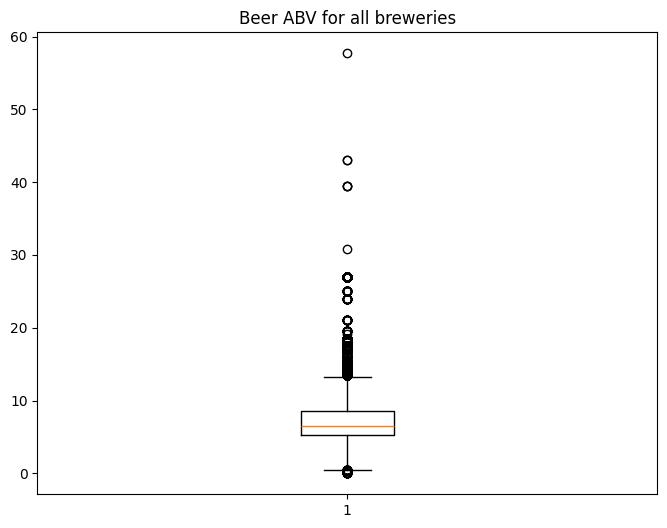

In [16]:
# Plot distribution of beer ABV for all breweries
plt.figure(figsize=(8, 6))
plt.title('Beer ABV for all breweries')
plt.boxplot(df['beer_ABV'])
plt.show()

### Year of highest ratings <a id='highest-ratings'></a>

Which year did beers have the highest ratings?

In [17]:
# Extract year from review timestamp
df['review_year'] = pd.to_datetime(df['review_time'], unit='s').dt.year

In [18]:
df_q2 = df.groupby(by='review_year', as_index=False).agg(n_reviews=('review_year', 'size'), mean_score=('review_overall', 'mean')).sort_values(by='mean_score', ascending=False)
df_q2

,review_year,n_reviews,mean_score
2,2000,29,4.241379
0,1998,11,4.045455
1,1999,10,4.000000
3,2001,534,3.970037
12,2010,90496,3.869679
11,2009,80456,3.868500
7,2005,27503,3.845799
10,2008,65931,3.840599
14,2012,3057,3.839058
13,2011,107164,3.833494


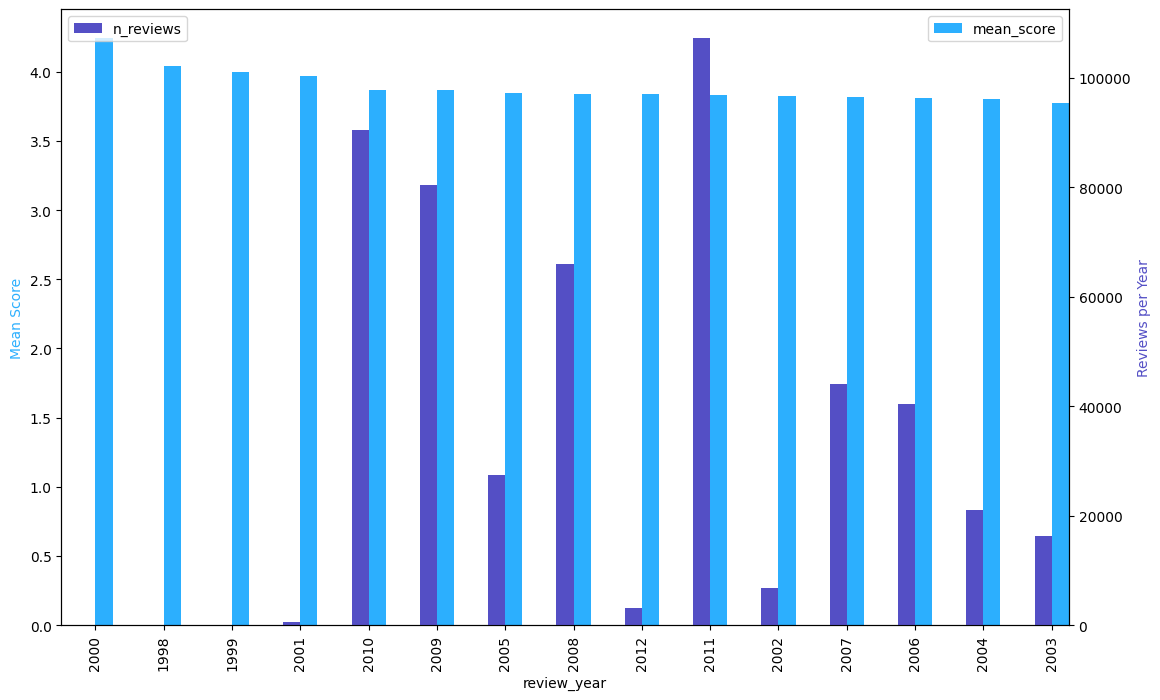

In [19]:
# Plot bar chart
color1 = '#2caffe'
color2 = '#544fc5'

fig, ax1 = plt.subplots(figsize=(13, 8))

df_q2.plot(x='review_year', y='mean_score', kind='bar', color=color1, ax=ax1, width=0.25, position=0)
ax2 = ax1.twinx()
df_q2.plot(x='review_year', y='n_reviews', kind='bar', color=color2, ax=ax2, width=0.25, position=1)

ax1.set_ylabel('Mean Score', color=color1)
ax2.set_ylabel('Reviews per Year', color=color2)

plt.legend(loc='upper left')

plt.show()

The year that had the highest beer ratings was `2010`.

The years with the top 4 highest mean scores had very low numbers of reviews per year. Here, it is assumed these years have insufficient data to contribute to analysis results.

### Important factors for taste, aroma, appearance, and palette <a id='important-factors'></a>

Based on the users' ratings, which factors are important among taste, aroma, appearance, and palette?

To determine the importance between the factors and the users' overall ratings, the correlation coefficient can be calculated and used as an importance measure.

In [20]:
df_q3 = df.groupby(by='beer_beerId')[['review_taste', 'review_aroma', 'review_appearance', 'review_palette', 'review_overall']].mean()
df_q3

,review_taste,review_aroma,review_appearance,review_palette,review_overall
beer_beerId,,,,,
5,3.323810,3.342857,3.488095,3.208333,3.554762
6,3.514925,3.645235,3.838691,3.516073,3.709529
7,3.110687,3.103817,3.251145,3.178626,3.271756
8,3.301471,3.235294,3.294118,3.080882,3.647059
9,3.103448,3.043103,3.051724,2.853448,3.400862
...,...,...,...,...,...
77302,3.500000,3.500000,3.000000,3.000000,3.500000
77303,5.000000,4.500000,4.500000,4.500000,5.000000
77305,3.500000,4.000000,4.000000,4.000000,4.000000


In [21]:
df_q3.corr()

,review_taste,review_aroma,review_appearance,review_palette,review_overall
review_taste,1.000000,0.835088,0.682127,0.756303,0.823181
review_aroma,0.835088,1.000000,0.660223,0.825980,0.883871
review_appearance,0.682127,0.660223,1.000000,0.669148,0.637575
review_palette,0.756303,0.825980,0.669148,1.000000,0.766908
review_overall,0.823181,0.883871,0.637575,0.766908,1.000000


Here, the aroma is the most important factor for the beer with a 0.88 correlation with the overall review rating. The taste is the second most important factor, followed by palette and appearance. All of the factors are positively correlated with user ratings.

<Axes: >

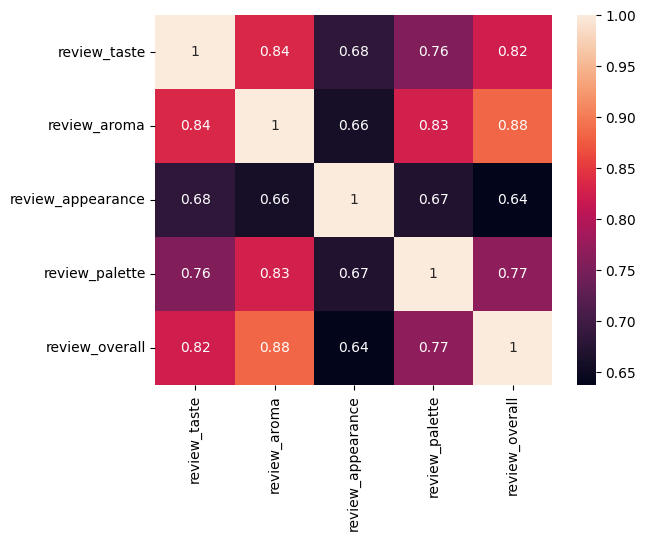

In [22]:
heatmap(data=df_q3.corr(), annot=True)

### Top 3 recommendations <a id='top-recommendations'></a>

If you were to recommend 3 beers to your friends based on this data, which ones would you recommend?

Recommend beers that are reviewed most often, and most highly.

In [23]:
df_q4 = df.groupby(by='beer_beerId', as_index=False).agg(n_reviews=('review_overall', 'count'), mean_score=('review_overall', 'mean'))
df_q4

,beer_beerId,n_reviews,mean_score
0,5,420,3.554762
1,6,871,3.709529
2,7,655,3.271756
3,8,68,3.647059
4,9,116,3.400862
...,...,...,...
14985,77302,1,3.500000
14986,77303,1,5.000000
14987,77305,1,4.000000
14988,77307,1,4.000000


In [24]:
# Check top 10 beers by mean score
df_q4.nlargest(n=10, columns='mean_score', keep='all')

,beer_beerId,n_reviews,mean_score
192,1057,1,5.0
349,1734,1,5.0
906,4911,1,5.0
992,5321,1,5.0
1064,5725,1,5.0
...,...,...,...
14679,75949,1,5.0
14723,76150,1,5.0
14814,76563,1,5.0
14977,77207,1,5.0


These beers have only been reviewed once. It is better to recommend beers that have more reviews.

In [25]:
df_q4.describe()

,beer_beerId,n_reviews,mean_score
count,14990.000000,14990.000000,14990.000000
mean,40740.290527,33.602201,3.651688
std,22634.524770,140.888150,0.625075
min,5.000000,1.000000,1.000000
25%,20957.250000,1.000000,3.400000
50%,42341.500000,3.000000,3.750000
75%,60703.250000,10.000000,4.000000
max,77310.000000,2928.000000,5.000000


The distribution of reviews appears skewed because over 50% of beers have less than 3 reviews.

array([[<Axes: title={'center': 'n_reviews'}>]], dtype=object)

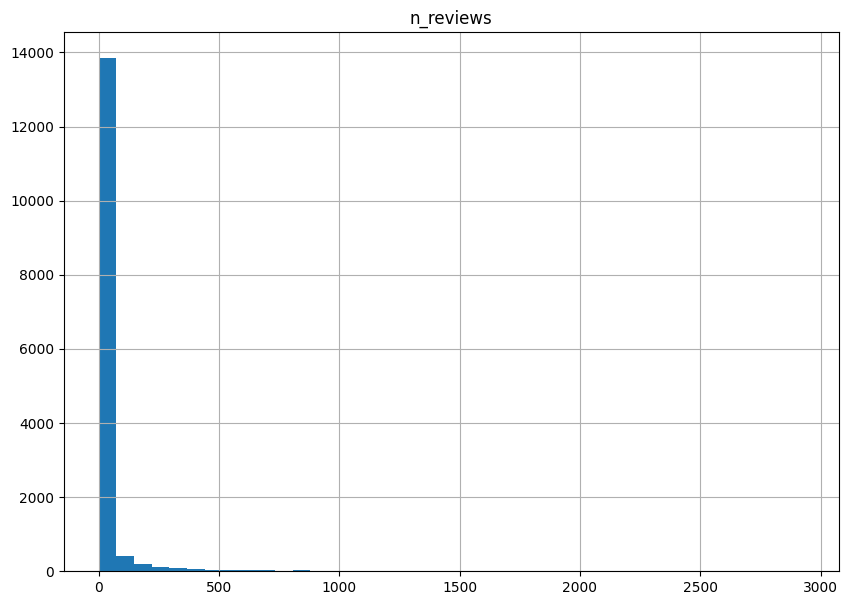

In [26]:
# Plot distribution of number of reviews of beers
df_q4.hist(column='n_reviews', bins=40, figsize=(10, 7))

The lowest bin contains most of the reviews. In this case, `200` reviews will be selected as a cut-off point above which beers will be recommended. The threshold for the number of reviews can be adjusted for experimentation.

array([[<Axes: title={'center': 'n_reviews'}>]], dtype=object)

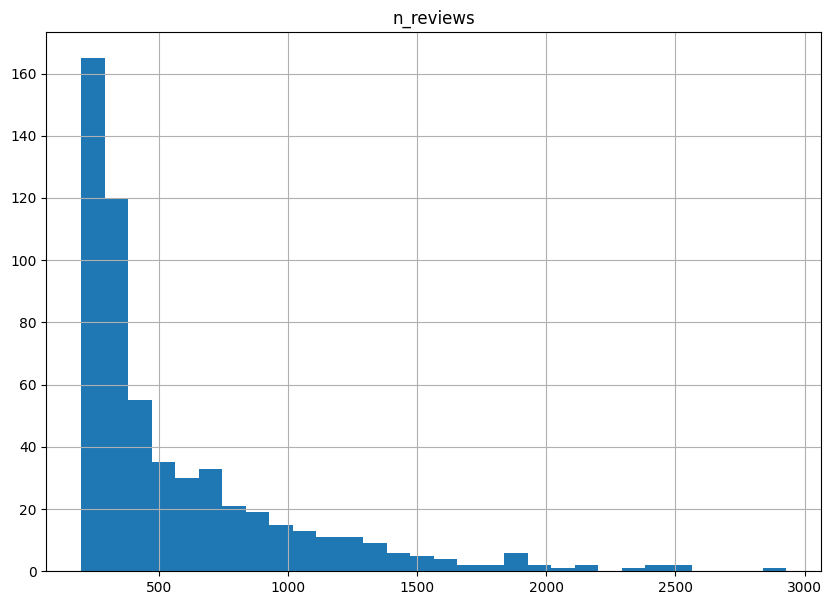

In [27]:
df_q4[df_q4['n_reviews'] > 200].hist(column='n_reviews', bins=30, figsize=(10, 7))

In [28]:
(df_q4[df_q4['n_reviews'] > 200].nlargest(n=3, columns='mean_score', keep='all')
 .merge(right=df, how='left', on='beer_beerId')
 .drop_duplicates(subset='beer_beerId')
 [['beer_name', 'beer_style']]
)

,beer_name,beer_style
0,Citra DIPA,American Double / Imperial IPA
246,Heady Topper,American Double / Imperial IPA
689,Founders CBS Imperial Stout,American Double / Imperial Stout


The top 3 beer recommendations are American Double style.

### Best beer style <a id='beer-style'></a>

Which beer style appears to be the favorite based on user reviews? How do the written reviews compare to overall review score for each beer style?

The `review_text` column contains text that can be analyzed with a natural language processing (NLP) model to classify sentiment as positive, negative, or neutral.

For this task, the Valence Aware Dictionary and sEntiment Reasoner ([VADER](https://github.com/cjhutto/vaderSentiment)) lexicon and rule-based sentiment analysis tool will be used.

In [29]:
# Download scored list of words and jargon that sentiment analyzer will reference for analysis
download('vader_lexicon', quiet=True)

True

In [30]:
analyser = SentimentIntensityAnalyzer()

Create a new column `review_sentiment` for the compound score of the `review_text` column.

The following cell may take several minutes to execute.

In [31]:
df['review_sentiment'] = df['review_text'].apply(lambda x: analyser.polarity_scores(text=x)['compound'])

In [32]:
df.groupby(by='beer_style')['review_sentiment'].agg(func=['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
beer_style,,
Quadrupel (Quad),0.857196,4808
Dortmunder / Export Lager,0.855261,1709
Flanders Red Ale,0.852629,2751
Roggenbier,0.850934,137
Braggot,0.850453,197
...,...,...
Happoshu,0.533456,55
American Malt Liquor,0.525378,1332
Japanese Rice Lager,0.514906,488


Based on user reviews, the most favored beer style is `Quadrupel (Quad)`. This style has received a high number of reviews.

To compare the written reviews to the overall review score for `Quadrupel (Quad)`, the correlation coefficient can be calculated.

In [33]:
df_q5 = df[df['beer_style'] == 'Quadrupel (Quad)']
df_q5[['review_sentiment', 'review_overall']].corr()

,review_sentiment,review_overall
review_sentiment,1.00000,0.25939
review_overall,0.25939,1.00000


There is a low positive correlation of 0.26 between the review score and the sentiment compound score.

A correlation matrix can be created to check the other review attributes. 

<Axes: >

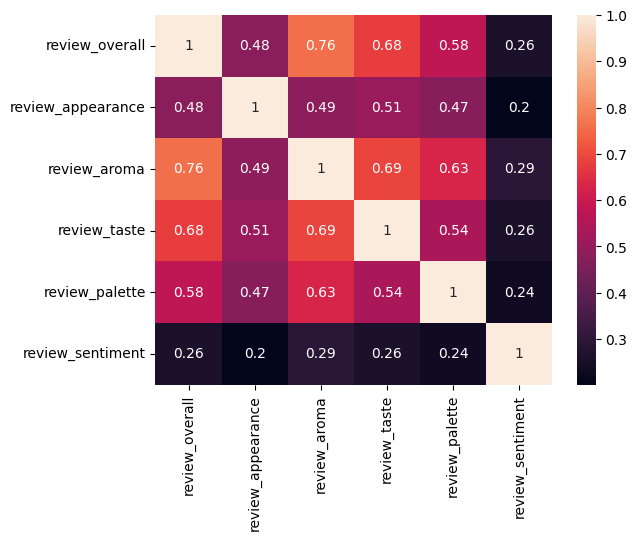

In [34]:
heatmap(data=df_q5[[
    'review_overall', 
    'review_appearance',
    'review_aroma',
    'review_taste',
    'review_palette',
    'review_sentiment'
]].corr(), annot=True)

All review attributes score similarly, at around 0.2 correlation. This consistency is expected because from a computer's perspective, a single number (the overall review) better expresses the users' opinions of the beer than the written text, given that the NLP model is not performing at human-level understanding. 

The low correlation coefficient could also be explained by users providing a high overall review score but writing neutral comments in the text.

The overall trend is positive coefficients, indicating that an increase in the compound score is correlated with an increase in the overall review score.

This notebook was inspired by the [Beer Data Analysis](https://platform.stratascratch.com/data-projects/beer-data-analysis) data project on [StrataScratch](https://www.stratascratch.com/).